# **Ovarian cancer classification**
### **About the dataset**

The dataset contains **5 different subtypes of ovarian cancer**:

1.   **HGSC** - High-Grade Serous Carcinoma
2.   **CC** - Clear-Cell Ovarian Carcinoma
3.   **EC** - Endometrioid
4.   **LGSC** - Low-Grade Serous
5.   **MC** - Mucinous Carcinoma

The dataset is divided into 2 different folders, one for training & validation and a different one for testing, each divided into the 5 different subtypes. The **training folder contains approximatively 31.000 images**, whereas the **test folder has 3000 images**. All images are characterized by distinct cellular morphologies, molecular and genetic profiles and clinical attributes. Subtype-specific treatment approaches are gaining prominence nowadays, though first requires subtype classification, a process that could be improved with data science and artificial intelligence.
Out of the training folder, I have used **80% of images for training** and **20% for validation**.

The **distribution of each class for the training folder** can be seen in the following picture:
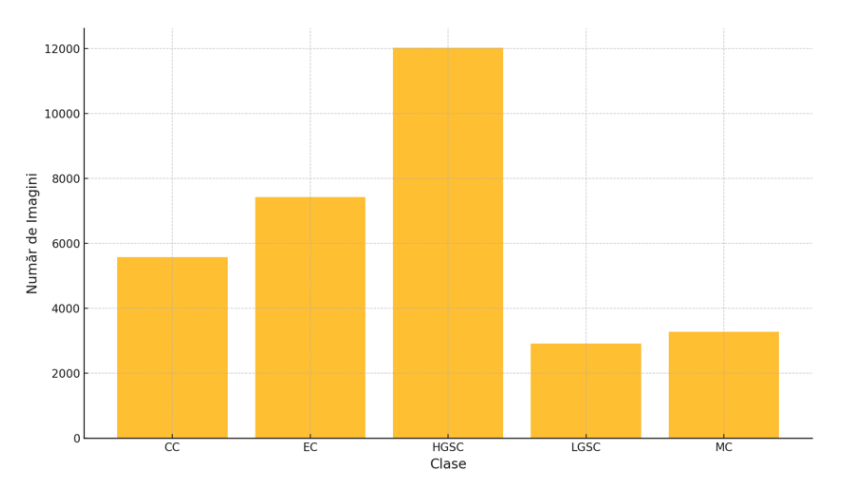



All images are stored in PNG format in the dataset, which does not support pyramidal data management like other standard digital pathology formats (example: SVS, TIFF, NDPI). This use of PNG format adds complexity to data handling.

The test set was also designed to evaluate the models' generalization ability, including images from different hospitals with significant variations in size, staining techniques and quality.

Thus, the dataset had some limitations overall:

*   Class imbalance, with some subtypes underrepresented.
*   PNG format complicates handling large images.
*   Significant variability among images, even within the same class.

## Imports


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

## Unzip files


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ColabNotebooks/ovarian_cancer_images.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/Train_Images/LGSC/18749.png  
  inflating: /content/Train_Images/LGSC/18750.png  
  inflating: /content/Train_Images/LGSC/19250.png  
  inflating: /content/Train_Images/LGSC/19251.png  
  inflating: /content/Train_Images/LGSC/19252.png  
  inflating: /content/Train_Images/LGSC/19253.png  
  inflating: /content/Train_Images/LGSC/19254.png  
  inflating: /content/Train_Images/LGSC/19255.png  
  inflating: /content/Train_Images/LGSC/19256.png  
  inflating: /content/Train_Images/LGSC/19257.png  
  inflating: /content/Train_Images/LGSC/19258.png  
  inflating: /content/Train_Images/LGSC/19260.png  
  inflating: /content/Train_Images/LGSC/19261.png  
  inflating: /content/Train_Images/LGSC/19262.png  
  inflating: /content/Train_Images/LGSC/19263.png  
  inflating: /content/Train_Images/LGSC/19264.png  
  inflating: /content/Train_Images/LGSC/19265.png  
  inflating: /content/Train_Images/LGSC/19266.png  
  inflating: 

## Load & Prepare Image Data

In [ ]:
###################################
# LOAD AND PREPARE IMAGE DATA
# MODIFY THE CODE BASED ON THE NUMBER OF CLASSES YOU
# WANT TO RUN THE CLASSIFICATION TASKS ON
###################################

# Update selected_classes to include all the classes
# you want to run classification task on
selected_classes = {"EC": 0, "CC": 1, "MC": 2, "HGSC": 3, "LGSC": 4}  # Mapping class names to numeric labels

images_list = []
labels = []

# Get all the folders in the training directory
train_images = os.listdir('/content/Train_Images')

# Filter only the selected classes
# Example: if you selected only 2 classes EC and CC,
# only keep those folders for EC and CC classes
filtered_classes = [folder_name for folder_name in train_images if folder_name in selected_classes]

if not filtered_classes:
    raise ValueError("No matching classes found in /content/Train_Images")

# Process images for selected classes
for folder_name in filtered_classes:
    folder_path = os.path.join('/content/Train_Images', folder_name)
    images = os.listdir(folder_path)
    class_label = selected_classes[folder_name]

    # Load all images in the folder
    for image_name in images:
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)

        if image is not None:
            # Resize images to 224x224 for the neural network
            image = cv2.resize(image, (224, 224))
            images_list.append(image)
            labels.append(class_label)
        else:
            print(f"Error reading image: {image_path}")

# Convert to numpy arrays
images_list = np.array(images_list)
labels = np.array(labels)

# Checks
print("Selected classes:")
for class_name, label in selected_classes.items():
    print(f"Class {label}: {class_name}")

print("Raw image shape:", images_list.shape)

Selected classes:
Class 0: EC
Class 1: CC
Class 2: MC
Class 3: HGSC
Class 4: LGSC
Raw image shape: (31203, 224, 224, 3)
Labels shape: (31203,)


In [ ]:
# Other checks

from collections import Counter

print(Counter(labels))

Counter({3: 12019, 0: 7421, 1: 5579, 2: 3276, 4: 2908})


### Preprocess images and split training dataset

In [ ]:
# Preprocess images for ResNet50
# This also scales from 0..255 to appropriate range
images_list = preprocess_input(images_list)

# Split data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    images_list,
    labels,
    test_size=0.2,
    random_state=42
)

## Build ResNet-50

In [ ]:
###################################
# BUILD A PRETRAINED RESNET-50
###################################

# Change this value depending on the number of classes
# you run classification for
num_classes = 5

# Load the ResNet50 base model with ImageNet weights excluding top layers
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freezing some of the initial layers to preserve pretrained weights
# For testing, can also be removed
for layer in base_model.layers[:50]:
    layer.trainable = False

# Build a custom classification "head" on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_initializer=HeNormal())(x)
# Tests
# x = Dense(256, activation='relu', kernel_initializer=HeNormal())(x)
# x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = Dense(256, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

predictions = Dense(num_classes, activation='softmax')(x)

# Final model object
resnet_model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Compile model ResNet-50

In [ ]:
###################################
# COMPILE MODEL
###################################

# Add optimizer
optimizer = Adam(learning_rate=1e-4)

resnet_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Data augmentation

In [ ]:
###################################
# DATA AUGMENTATION
###################################

# Change values for testing if necessary
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.20,
    height_shift_range=0.20,
    shear_range=0.20,
    zoom_range=0.20,
    horizontal_flip=True,
    fill_mode='nearest'
)

## Callbacks

In [ ]:
###################################
# CALLBACKS
###################################

check_dir = './check'
os.makedirs(check_dir, exist_ok=True)

epochs = 100 # change if needed
checkpoint_path = os.path.join(check_dir, f'{epochs}__ckpt__.weights.h5')

check = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Change patience for tests
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Change patience/ learning rate for tests
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=1e-7,
    verbose=1
)

callbacks = [check, early_stop, reduce_lr]

## Train the model

In [ ]:
###################################
# TRAIN THE MODEL
###################################

# Create augmented generator for the training data
train_flow = datagen.flow(train_data, train_labels, batch_size=32)

history = resnet_model.fit(
    train_flow,
    validation_data=(val_data, val_labels),
    epochs=epochs,
    callbacks=callbacks
)

###################################
# SAVE THE FINAL MODEL
###################################

resnet_model.save('resnet_model11.h5')

print("Training complete. Model saved to resnet_model.h5.")

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


780/781 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.5044 - loss: 1.4103
Epoch 1: val_loss improved from inf to 0.81903, saving model to ./check/100__ckpt__.weights.h5
781/781 ━━━━━━━━━━━━━━━━━━━━ 320s 349ms/step - accuracy: 0.5046 - loss: 1.4097 - val_accuracy: 0.7201 - val_loss: 0.8190 - learning_rate: 1.0000e-04
Epoch 2/100
780/781 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.6829 - loss: 0.8618
Epoch 2: val_loss improved from 0.81903 to 0.63342, saving model to ./check/100__ckpt__.weights.h5
781/781 ━━━━━━━━━━━━━━━━━━━━ 249s 315ms/step - accuracy: 0.6829 - loss: 0.8617 - val_accuracy: 0.7755 - val_loss: 0.6334 - learning_rate: 1.0000e-04
Epoch 3/100
780/781 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.7410 - loss: 0.6895
Epoch 3: val_loss did not improve from 0.63342
781/781 ━━━━━━━━━━━━━━━━━━━━ 247s 313ms/step - accuracy: 0.7411 - loss: 0.6894 - val_accuracy: 0.7093 - val_loss: 0.9057 - learning_rate: 1.0000e-04
Epoch 4/100
780/781 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - 

Training complete. Model saved to resnet_model.h5.


## Results

196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Classification Report:
              precision    recall  f1-score   support

          EC       0.87      0.82      0.84      1476
          CC       0.88      0.92      0.90      1130
          MC       0.93      0.85      0.89       656
        HGSC       0.90      0.91      0.91      2385
        LGSC       0.81      0.87      0.84       594

    accuracy                           0.88      6241
   macro avg       0.88      0.88      0.88      6241
weighted avg       0.88      0.88      0.88      6241



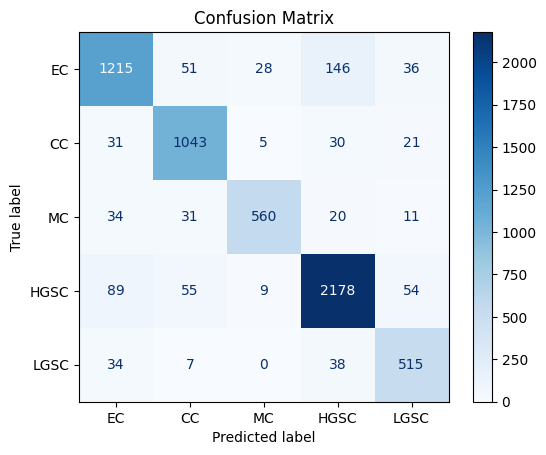

Overall Accuracy: 0.88


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate Predictions
y_pred_prob = resnet_model.predict(val_data)  # val_data = validation dataset
y_pred = np.argmax(y_pred_prob, axis=1)       # Convert probabilities to class indices

# Calculate Metrics
print("Classification Report:")
print(classification_report(val_labels, y_pred, target_names=["EC", "CC", "MC", "HGSC", "LGSC"]))

# Generate Confusion Matrix
conf_matrix = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["EC", "CC", "MC","HGSC", "LGSC"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Overall Accuracy
accuracy = np.mean(y_pred == val_labels)
print(f"Overall Accuracy: {accuracy:.2f}")

# Predictions on test data

Loaded 3082 test images.


Loaded the trained model.
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
Classification Report:
              precision    recall  f1-score   support

          EC       0.87      0.82      0.84       733
          CC       0.88      0.91      0.90       551
          MC       0.90      0.84      0.87       323
        HGSC       0.90      0.92      0.91      1188
        LGSC       0.79      0.87      0.83       287

    accuracy                           0.88      3082
   macro avg       0.87      0.87      0.87      3082
weighted avg       0.88      0.88      0.88      3082

Confusion Matrix:
[[ 598   27   18   73   17]
 [  17  502    3   18   11]
 [  11   14  272   14   12]
 [  41   24    7 1090   26]
 [  17    2    2   15  251]]


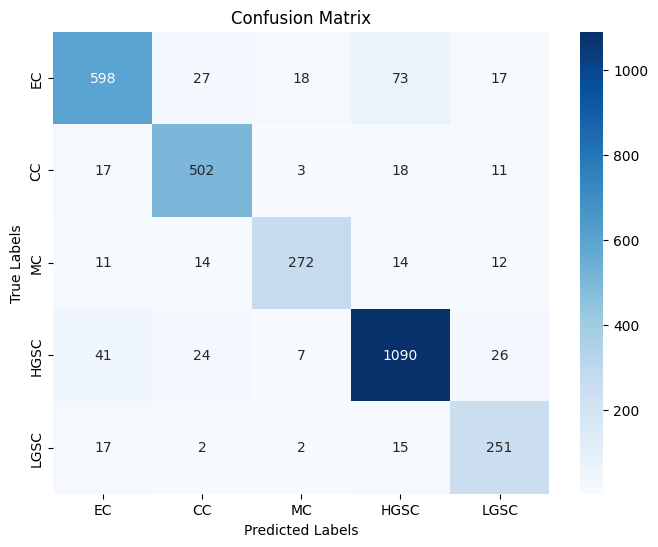

Overall Accuracy: 0.88


In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

###################################
# LOAD TEST DATA
###################################

# Test folder paths
test_folder = '/content/Test_Images'
categories = ['EC', 'CC', 'MC', 'HGSC', 'LGSC']  # Class folder names
num_classes = len(categories)

test_images = []
test_labels = []

# Load all test images per category
for label, category in enumerate(categories):
    category_path = os.path.join(test_folder, category)
    images = os.listdir(category_path)

    for image_name in images:
        image_path = os.path.join(category_path, image_name)
        image = cv2.imread(image_path)

        if image is not None:
            image = cv2.resize(image, (224, 224))
            test_images.append(image)
            test_labels.append(label)
        else:
            print(f"Error reading image: {image_path}")

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Normalize test images using the same preprocessing used for training
from tensorflow.keras.applications.resnet50 import preprocess_input

test_images = preprocess_input(test_images)

print(f"Loaded {len(test_images)} test images.")

###################################
# LOAD THE TRAINED MODEL
###################################

# Path to your saved model
# model_path = './check/best_resnet_model.keras'
model_path = './resnet_model11.h5'

# Load the model
model = load_model(model_path)
print("Loaded the trained model.")

###################################
# EVALUATE THE MODEL
###################################

# Predict on the test set
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=categories))

print("Confusion Matrix:")
cm = confusion_matrix(test_labels, predicted_labels)
print(cm)

###################################
# PLOT CONFUSION MATRIX
###################################

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

###################################
# OVERALL ACCURACY
###################################

# Calculate overall accuracy
accuracy = np.mean(predicted_labels == test_labels)
print(f"Overall Accuracy: {accuracy:.2f}")


In [ ]:
# Predict on the test images
predictions = resnet_model.predict(test_images, batch_size=1)
predicted_labels = np.argmax(predictions, axis=1)

# Print results
print("\nPrediction Results:")
for i in range(len(test_images)):
    print(f"Image {i + 1}: Predicted = {predicted_labels[i]}, Actual = {test_labels[i]}")

# Calculate and display accuracy on the test set
test_accuracy = np.mean(predicted_labels == test_labels)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")


In [ ]:
import hashlib
import os

def compute_image_hash(image_path):
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

# Compute hashes for each dataset
train_hashes = [compute_image_hash(os.path.join('/content/Train_Images', folder, img))
                for folder in os.listdir('/content/Train_Images')
                for img in os.listdir(os.path.join('/content/Train_Images', folder))]

test_hashes = [compute_image_hash(os.path.join('/content/Test_Images', folder, img))
               for folder in os.listdir('/content/Test_Images')
               for img in os.listdir(os.path.join('/content/Test_Images', folder))]

# Find any overlap
overlap = set(train_hashes).intersection(set(test_hashes))
print(f"Number of overlapping images: {len(overlap)}")

Number of overlapping images: 1


In [ ]:
import collections

train_class_counts = collections.Counter(train_labels)
print(f"Training class distribution: {train_class_counts}")

Training class distribution: Counter({1: 1620, 2: 1617, 0: 1563})
